## Imports

In [9]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms
from tqdm import tqdm

In [10]:
from lstm import LSTM
from ddpm import UNET, inference
from grayscott import GrayScott, laplacian
from training import train_lstm, train_ddpm
from constants import *

## Device

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## LSTM Dataset

In [12]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

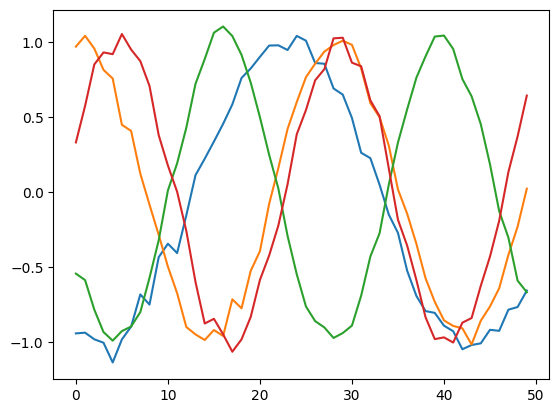

In [13]:
samples = create_sine_dataset(100,50)
samples.size()
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

In [14]:
def create_lorenz_dataset(samples=100, seq_len=100, dt=0.01):
    """
    Generates chaotic time series data from the Lorenz Attractor.
    """
    data = []
    # Lorenz Parameters
    sigma, rho, beta = 10.0, 28.0, 8.0/3.0
    
    for _ in range(samples):
        # Random start state
        state = np.random.randn(3)
        sequence = []
        
        for _ in range(seq_len):
            x, y, z = state
            # Euler Integration
            dx = sigma * (y - x)
            dy = x * (rho - z) - y
            dz = x * y - beta * z
            
            state = state + np.array([dx, dy, dz]) * dt
            # We only use the 'x' dimension for the 1D LSTM task
            sequence.append(state[0])
            
        data.append(sequence)
    
    # Normalize to [-1, 1] for LSTM stability
    data = np.array(data)
    data = (data - np.mean(data)) / np.std(data)
    
    return torch.FloatTensor(data).unsqueeze(2) # [Batch, Seq, 1]

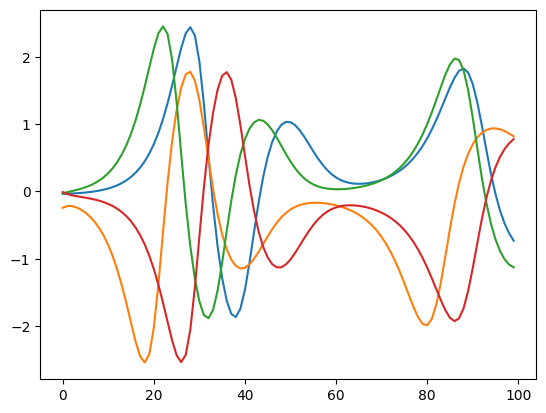

In [15]:
samples_lorenz = create_lorenz_dataset(100, 100, 0.02)
samples_lorenz.size()
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples_lorenz[rand_index,:,0])

## LSTM Training

In [16]:
n_samples = 1000
seq_len = 100
n_epochs = 200

In [17]:
lstm_data_sine = create_sine_dataset(samples=n_samples, seq_len=seq_len).to(device)
lstm_data_lorenz = create_lorenz_dataset(samples=n_samples, seq_len=seq_len, dt=0.02).to(device)
lstm_model_sine = LSTM(input_size=1, hidden_size=16).to(device)
lstm_model_lorenz = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM on cpu ---
Epoch 0: Loss 0.54071
Epoch 10: Loss 0.16131
Epoch 20: Loss 0.05447
Epoch 30: Loss 0.02443
Epoch 40: Loss 0.01757
Epoch 50: Loss 0.01267
Epoch 60: Loss 0.01024
Epoch 70: Loss 0.00922
Epoch 80: Loss 0.00854
Epoch 90: Loss 0.00804
Epoch 100: Loss 0.00770
Epoch 110: Loss 0.00745
Epoch 120: Loss 0.00724
Epoch 130: Loss 0.00707
Epoch 140: Loss 0.00693
Epoch 150: Loss 0.00681
Epoch 160: Loss 0.00671
Epoch 170: Loss 0.00662
Epoch 180: Loss 0.00655
Epoch 190: Loss 0.00648


Text(0.5, 0, 'epoch')

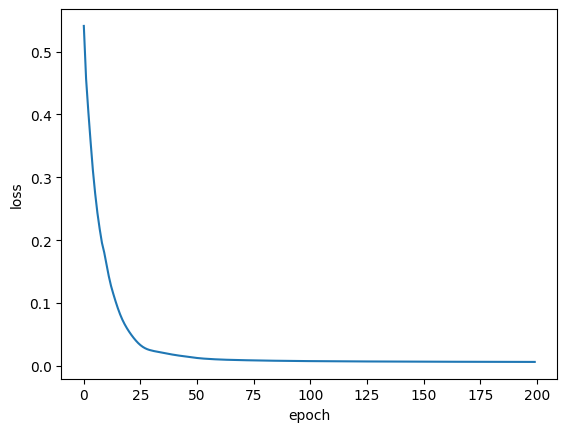

In [18]:
loss_lstm_sine = train_lstm(lstm_model_sine, lstm_data_sine, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm_sine)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([100, 1])
Seed values: tensor([[-0.8671],
        [-0.8692],
        [-0.9114],
        [-0.8639],
        [-0.9551]])
Generated shape: torch.Size([200, 1])
Generated values: tensor([[-0.5706],
        [-0.8208],
        [-0.8487],
        [-0.8595],
        [-0.8373]])


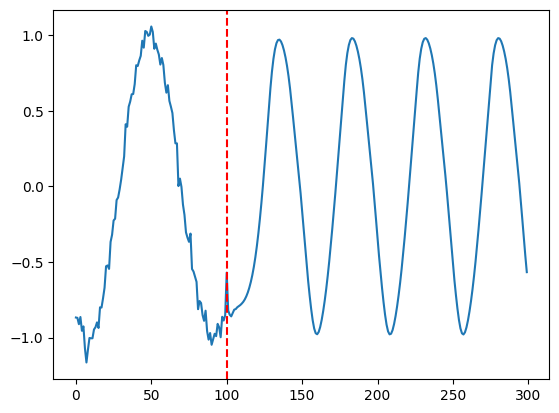

In [19]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data_sine[rand_index]

future_steps = 2*seq_len
generated_sine, history_generated_sine = lstm_model_sine.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated_sine.shape}")
print(f"Generated values: {generated_sine[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated_sine.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

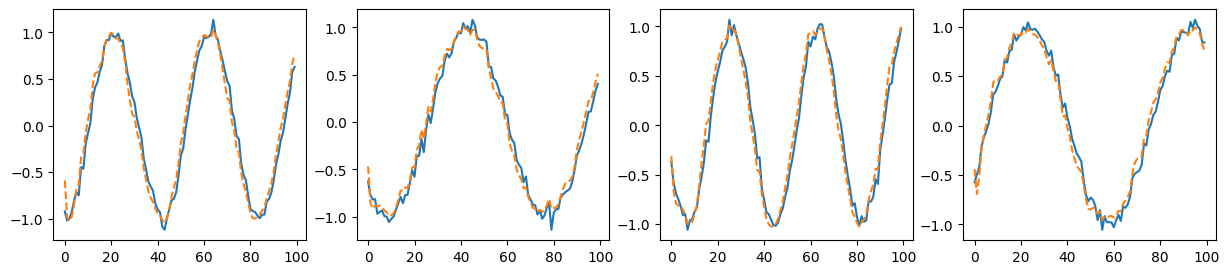

In [20]:
lstm_out_sine, history_lstm_sine = lstm_model_sine(lstm_data_sine)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_data_sine[rand_index,:,0].to("cpu").detach().numpy(), label="true data")
    ax[i].plot(lstm_out_sine[rand_index,:,0].to("cpu").detach().numpy(), linestyle="--", label="lstm output")

plt.show()

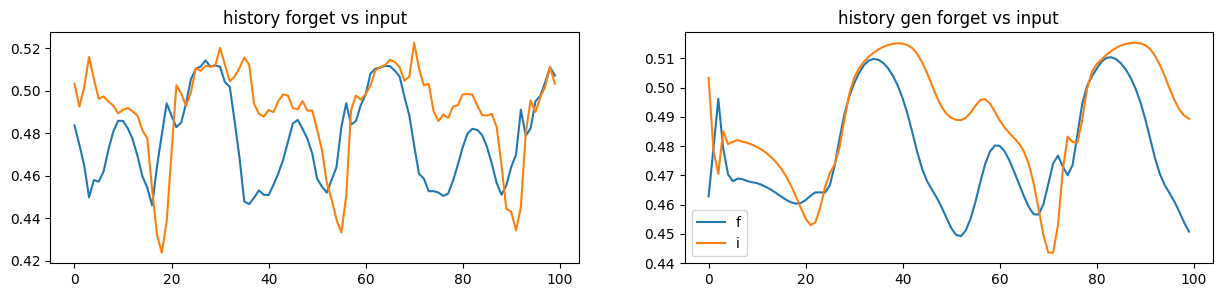

In [21]:
rand_index = random.randint(0,n_samples)
forget_sine = [[t[rand_index, d].item() for t in history_lstm_sine["forget"]] for d in range(16)]
input_sine = [[t[rand_index, d].item() for t in history_lstm_sine["input"]] for d in range(16)]
forget_sine_gen = [[t[0, d].item() for t in history_generated_sine["forget"]] for d in range(16)]
input_sine_gen = [[t[0, d].item() for t in history_generated_sine["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l

forget_mean_sine = mean_forget(forget_sine)
input_mean_sine = mean_forget(input_sine)
forget_mean_sine_gen = mean_forget(forget_sine_gen)
input_mean_sine_gen = mean_forget(input_sine_gen)

fix, ax = plt.subplots(1,2, figsize=(15,3))
ax[0].plot(forget_mean_sine, label="f")
ax[0].plot(input_mean_sine, label="i")
ax[0].set_title("history forget vs input")
ax[1].plot(forget_mean_sine_gen, label="f")
ax[1].plot(input_mean_sine_gen, label="i")
ax[1].set_title("history gen forget vs input")
plt.legend()
plt.show()

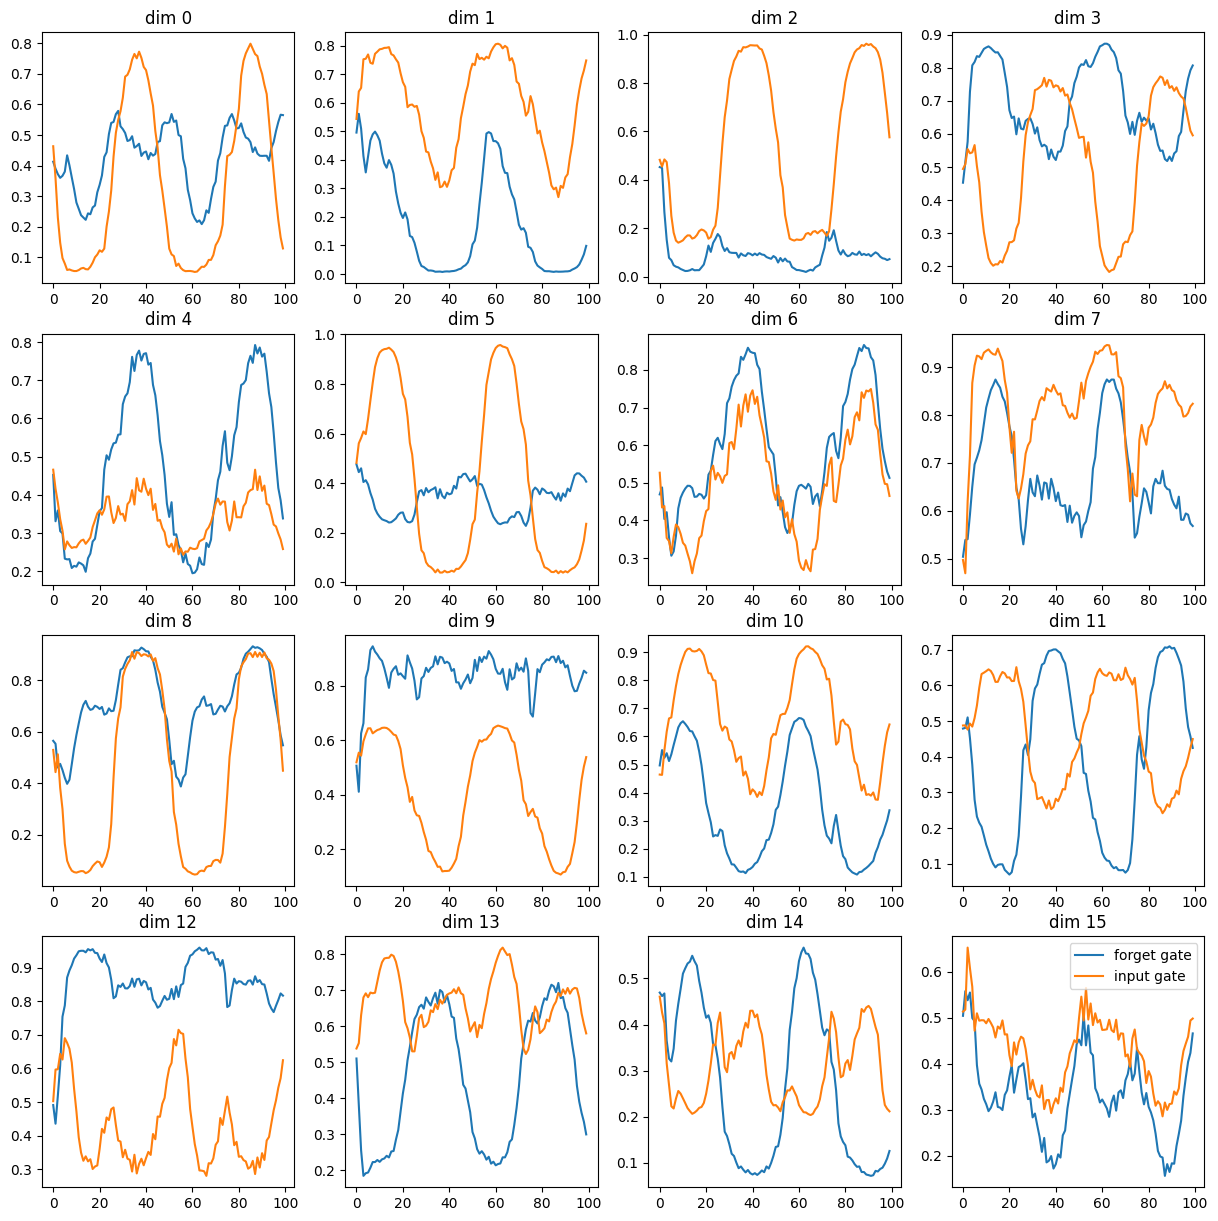

In [22]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_gate_sine = [[t[rand_sample, d].item() for t in history_lstm_sine["forget"]] for d in range(16)]
input_gate_sine = [[t[rand_sample, d].item() for t in history_lstm_sine["input"]] for d in range(16)]

for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget_gate_sine[4*i+j], label="forget gate")
        ax[i,j].plot(input_gate_sine[4*i+j], label="input gate")
        ax[i,j].set_title(f"dim {4*i+j}")

plt.legend()
plt.show()

--- Training LSTM on cpu ---
Epoch 0: Loss 1.06093
Epoch 10: Loss 0.60011
Epoch 20: Loss 0.29087
Epoch 30: Loss 0.14703
Epoch 40: Loss 0.08951
Epoch 50: Loss 0.05626
Epoch 60: Loss 0.03337
Epoch 70: Loss 0.01868
Epoch 80: Loss 0.01058
Epoch 90: Loss 0.00667
Epoch 100: Loss 0.00470
Epoch 110: Loss 0.00375
Epoch 120: Loss 0.00308
Epoch 130: Loss 0.00260
Epoch 140: Loss 0.00226
Epoch 150: Loss 0.00199
Epoch 160: Loss 0.00177
Epoch 170: Loss 0.00159
Epoch 180: Loss 0.00143
Epoch 190: Loss 0.00130


Text(0.5, 0, 'epoch')

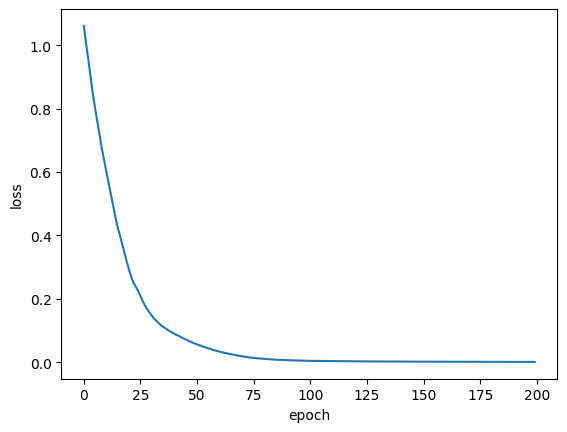

In [23]:
loss_lstm_lorenz = train_lstm(lstm_model_lorenz, lstm_data_lorenz, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm_lorenz)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([100, 1])
Seed values: tensor([[-0.0706],
        [-0.0594],
        [-0.0601],
        [-0.0689],
        [-0.0840]])
Generated shape: torch.Size([200, 1])
Generated values: tensor([[-0.2289],
        [-0.4277],
        [-0.7299],
        [-1.0456],
        [-1.2963]])


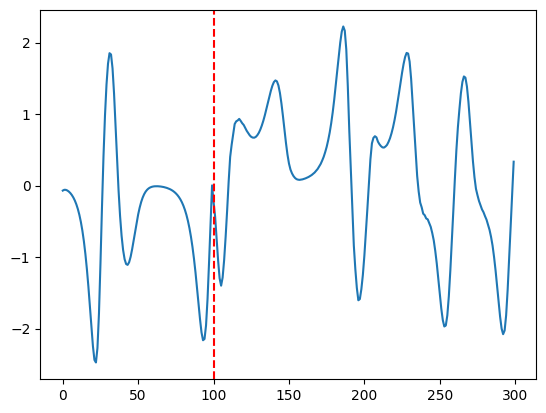

In [24]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data_lorenz[rand_index]

future_steps = 2*seq_len
generated_lorenz, history_generated_lorenz = lstm_model_lorenz.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated_lorenz.shape}")
print(f"Generated values: {generated_lorenz[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated_lorenz.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

## DDPM Training

In [25]:
n_epoch = 5
batch_size = 128
n_T = 1000

In [26]:
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
train_dataset_fashion = datasets.FashionMNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True,transform=transforms.ToTensor())

ddpm_model_notrain = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)
ddpm_model_mnist = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)
ddpm_model_fashion = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)
ddpm_model_cifar = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8,  # Reduce groups since channels are smaller
                  input_channels=3,
                  output_channels=3,
              ).to(device)

Starting inference on cpu with 1000 steps...


999it [00:46, 21.65it/s]


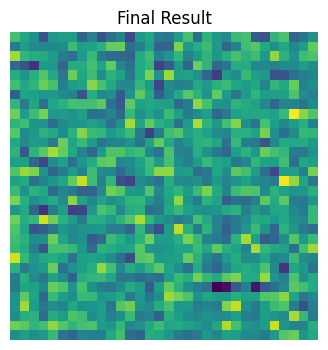

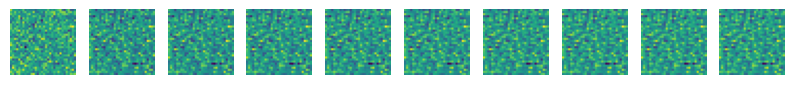

In [60]:
history_ddpm_notrain = inference(ddpm_model=ddpm_model_notrain, num_time_steps=n_T)

In [ ]:
losses_ddpm_mnist = train_ddpm(model=ddpm_model_mnist, data=train_dataset_mnist, batch_size=batch_size,num_time_steps=n_T, lr=2e-5, num_epochs=n_epoch, device=device, dataset_size=128)

plt.plot(losses_ddpm_mnist)
plt.ylabel("loss")
plt.xlabel("epoch")

Starting inference on cpu with 1000 steps...


999it [00:48, 20.72it/s]


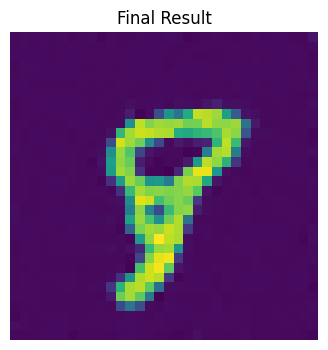

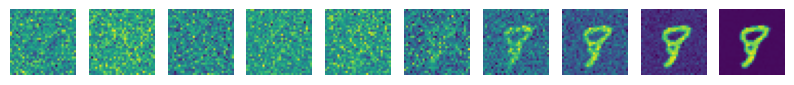

In [ ]:
history_ddpm_mnist = inference(ddpm_model=ddpm_model_mnist, checkpoint_path="checkpoints/ddpm_checkpoint_mnist", num_time_steps=n_T, channels=1, img_size=32)

Starting inference on cpu with 1000 steps...


999it [01:16, 13.09it/s]


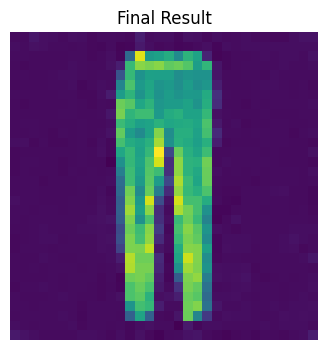

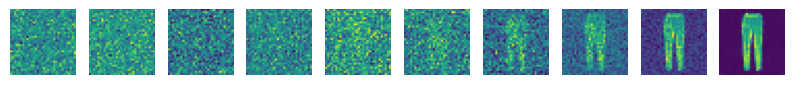

In [ ]:
history_ddpm_fashion = inference(ddpm_model=ddpm_model_fashion, checkpoint_path="checkpoints/ddpm_checkpoint_fashion", num_time_steps=n_T, channels=1, img_size=32)

In [ ]:
history_ddpm_cifar = inference(ddpm_model=ddpm_model_cifar, checkpoint_path="checkpoints/ddpm_checkpoint_cifar", num_time_steps=n_T, channels=3, img_size=32)

## Comparison

### Helper functions

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch
# from grayscott import GrayScott, laplacian

# def run_sweep():
#     # Range of F to sweep (covers extinction, spots, stripes, and chaos)
#     # Pearson classification typically: 
#     # F < 0.01: Extinction
#     # 0.02 < F < 0.04: Spots/Stripes (Stable)
#     # F > 0.06: Chaos/Saturation
#     f_values = np.linspace(0.01, 0.08, 20)
#     k_fixed = 0.062
    
#     ratios = []
#     stability_regimes = []

#     print(f"Starting Parameter Sweep over F (k={k_fixed})...")

#     for f in tqdm(f_values):
#         # Initialize model
#         gs = GrayScott(F=f, k=k_fixed, N=64)
        
#         # Run to equilibrium (or max steps)
#         # We need enough steps for the pattern to emerge
#         for _ in range(15000):
#             gs.step()
        
#         # Measure Forces at steady state
#         U_view = gs.U[1:-1, 1:-1]
#         V_view = gs.V[1:-1, 1:-1]
        
#         # Diffusion Force |D_v * Lap_v|
#         # (Using V usually gives cleaner structure metric for spots)
#         lap_v = laplacian(gs.V, gs.dx)
#         diff_force = np.mean(np.abs(gs.D_v * lap_v))
        
#         # Reaction Force |uv^2 - (F+k)v|
#         uv2 = U_view * V_view**2
#         react_force = np.mean(np.abs(uv2 - (gs.F + gs.k) * V_view))
        
#         # Calculate Ratio
#         if diff_force < 1e-9: # Avoid division by zero in extinction
#             ratio = 0.0
#         else:
#             ratio = react_force / diff_force
            
#         ratios.append(ratio)
        
#         # Simple heuristic for regime classification based on V concentration
#         max_v = np.max(V_view)
#         if max_v < 0.05:
#             stability_regimes.append("Extinction")
#         elif max_v > 0.1:
#             stability_regimes.append("Pattern")
#         else:
#             stability_regimes.append("Unstable")

#     return f_values, ratios, stability_regimes

# def plot_sweep(f_values, ratios, regimes):
#     plt.figure(figsize=(10, 6))
    
#     # Color code the points
#     colors = {'Extinction': 'gray', 'Pattern': 'green', 'Unstable': 'red'}
#     c_map = [colors[r] for r in regimes]
    
#     plt.scatter(f_values, ratios, c=c_map, s=100, zorder=2)
#     plt.plot(f_values, ratios, 'k--', alpha=0.3, zorder=1)
    
#     # Highlight the "Golden Ratio" line
#     plt.axhline(y=1.0, color='blue', linestyle='-', alpha=0.5, label='Perfect Balance (R=1)')
    
#     plt.title("Stability Landscape: Feed Rate vs. Dynamic Balance Ratio")
#     plt.xlabel("Feed Rate (F)")
#     plt.ylabel("Ratio R (Reaction / Diffusion)")
#     plt.grid(True, alpha=0.3)
    
#     # Create custom legend
#     from matplotlib.lines import Line2D
#     legend_elements = [
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Stable Pattern'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='Extinction/Empty'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Chaos/Saturation'),
#         Line2D([0], [0], color='blue', label='Theory Prediction (R=1)')
#     ]
#     plt.legend(handles=legend_elements)
    
#     plt.savefig("parameter_sweep.png")
#     print("Saved parameter_sweep.png")
#     plt.show()

# f, r, reg = run_sweep()
# plot_sweep(f, r, reg)

In [6]:
def run_rd_exp(history):
    print("=== RD Analysis ===")
    
    diff_forces, react_forces = [], []
    dx = history["dx"]
    F = history["F"]
    k = history["k"]
    D_u = history["D_u"]
    D_v = history["D_v"]

    for t in range(len(history["V"])):
        U_t = history["U"][t]
        V_t = history["V"][t]

        lap_V = torch.tensor(laplacian(V_t, dx))
        f_diff = torch.mean(torch.linalg.norm(D_v * lap_V)).item()

        uv2 = U_t * V_t**2
        reaction_V = torch.tensor(uv2 - (F + k) * V_t)
        f_react = torch.mean(torch.linalg.norm(reaction_V)).item()

        diff_forces.append(f_diff)
        react_forces.append(f_react)

    # Metrics: Mean magnitude per cell
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)
    
    print(f"RD Diffusion Force: {m_diff}")
    print(f"RD Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces


def run_lstm_exp(history):
    print("=== LSTM Analysis ===")

    diff_forces, react_forces = [], []

    for t in range(len(history["input"])):
        i_t = history["input"][t]
        f_t = history["forget"][t]
        C_tilde = history["cell_update"][t]
        C_t = history["cell"][t]
        C_prev = history["cell"][t-1] if t > 0 else torch.zeros_like(C_t)
                
        # Reaction (Restoring Force): 
        # The force pushing the state to the new value (oscillation update)
        # Magnitude of new information injected: |i_t * C_tilde|
        f_react = torch.mean(torch.linalg.norm(i_t * C_tilde)).item()
        
        # Diffusion (Decay/Stabilization):
        # The force eroding the previous state (forgetting)
        # Magnitude of information removed: |(1 - f_t) * C_prev|
        f_diff = torch.mean(torch.linalg.norm((1 - f_t) * C_prev)).item()
        
        diff_forces.append(f_diff)
        react_forces.append(f_react)
            
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)

    print(f"LSTM Diffusion Force: {m_diff}")
    print(f"LSTM Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces

def run_ddpm_exp(history):
    print("=== DDPM Analysis ===")
    drift_forces = []
    noise_forces = []

    for t in range(len(history["time"])):
        drift_vector = torch.tensor(history["drift"][t])
        diffusion_term = torch.tensor(history["diffusion"][t])

        f_react = torch.mean(torch.linalg.norm(drift_vector)).item()
        drift_forces.append(f_react)

        f_diff = torch.mean(torch.linalg.norm(diffusion_term)).item()
        noise_forces.append(f_diff)

    m_diff = np.mean(noise_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Noise Force (Diff):  {m_diff}")
    print(f"DDPM Drift Force (React): {m_react}")
    
    return m_diff, m_react, noise_forces, drift_forces


### Results

In [3]:
rd_diff_mean_list, rd_react_mean_list, rd_diff_history_list, rd_react_history_list = [], [], [], []
lstm_diff_mean_list_sine, lstm_react_mean_list_sine, lstm_diff_history_list_sine, lstm_react_history_list_sine = [], [], [], []
lstm_diff_mean_list_lorenz, lstm_react_mean_list_lorenz, lstm_diff_history_list_lorenz, lstm_react_history_list_lorenz = [], [], [], []
ddpm_diff_mean_list_mnist, ddpm_react_mean_list_mnist, ddpm_diff_history_list_mnist, ddpm_react_history_list_mnist = [], [], [], []
ddpm_diff_mean_list_fashion, ddpm_react_mean_list_fashion, ddpm_diff_history_list_fashion, ddpm_react_history_list_fashion = [], [], [], []
ddpm_diff_mean_list_cifar, ddpm_react_mean_list_cifar, ddpm_diff_history_list_cifar, ddpm_react_history_list_cifar = [], [], [], []

n_simul = 3

In [54]:
F_list = np.linspace(0.029, 0.0545, n_simul) # spots to strides
k = 0.062
D_u = 1e-5
D_v = 0.5e-5
T_max = 10000
for f in F_list:
    gs = GrayScott(F=f, k=k,D_u=D_u, D_v=D_v, N=256)
    U, V, V_history, stability_time, diff_history_rd, history_rd = gs.forward(0,T_max, frame=True, data=False)
    rd_diff, rd_react, rd_diff_list, rd_react_list = run_rd_exp(history_rd)
    rd_diff_mean_list.append(rd_diff)
    rd_react_mean_list.append(rd_react)
    rd_diff_history_list.append(rd_diff_list)
    rd_react_history_list.append(rd_react_list)

F=0.029, k=0.062:  26%|██████████▊                              | 2170/8192 [00:26<01:14, 80.98it/s]


KeyboardInterrupt: 

In [27]:
for _ in range(n_simul):
    rand_index = random.randint(0, n_samples)
    seed_sample = lstm_data_sine[rand_index]
    seed_sample_random = torch.randn(seq_len, 1)
    generated_sine, history_lstm_gen_sine = lstm_model_sine.generate_sequence(seed_sample, future_steps=future_steps)
    lstm_diff_sine, lstm_react_sine, lstm_diff_list_sine, lstm_react_list_sine = run_lstm_exp(history_lstm_gen_sine)
    lstm_diff_mean_list_sine.append(lstm_diff_sine)
    lstm_react_mean_list_sine.append(lstm_react_sine)
    lstm_diff_history_list_sine.append(lstm_diff_list_sine)
    lstm_react_history_list_sine.append(lstm_react_list_sine)

=== LSTM Analysis ===
LSTM Diffusion Force: 1.5423008682739794
LSTM Reaction Force:  1.5561051901860452
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5354747499652843
LSTM Reaction Force:  1.5484782837743136
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5400070309938498
LSTM Reaction Force:  1.5489826807424651


In [28]:
for _ in range(n_simul):
    rand_index = random.randint(0, n_samples)
    seed_sample = lstm_data_lorenz[rand_index]
    seed_sample_random = torch.randn(seq_len, 1)
    generated_lorenz, history_lstm_gen_lorenz = lstm_model_lorenz.generate_sequence(seed_sample, future_steps=future_steps)
    lstm_diff_lorenz, lstm_react_lorenz, lstm_diff_list_lorenz, lstm_react_list_lorenz = run_lstm_exp(history_lstm_gen_lorenz)
    lstm_diff_mean_list_lorenz.append(lstm_diff_lorenz)
    lstm_react_mean_list_lorenz.append(lstm_react_lorenz)
    lstm_diff_history_list_lorenz.append(lstm_diff_list_lorenz)
    lstm_react_history_list_lorenz.append(lstm_react_list_lorenz)

=== LSTM Analysis ===
LSTM Diffusion Force: 1.5967594786505004
LSTM Reaction Force:  1.6226969732711063
=== LSTM Analysis ===
LSTM Diffusion Force: 1.7040539452778034
LSTM Reaction Force:  1.7253208100496225
=== LSTM Analysis ===
LSTM Diffusion Force: 1.7377673180858095
LSTM Reaction Force:  1.765323270804918


Starting inference on cpu with 1000 steps...


999it [00:28, 35.48it/s]


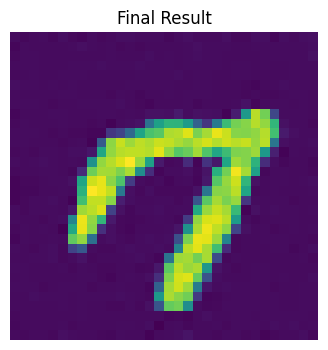

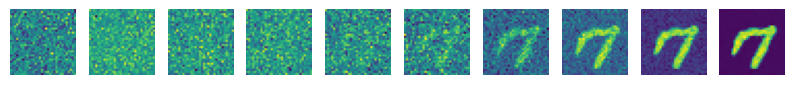

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.035944685488939
DDPM Drift Force (React): 0.2113402150273323
Starting inference on cpu with 1000 steps...


999it [00:27, 35.71it/s]


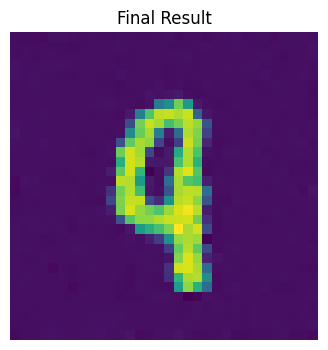

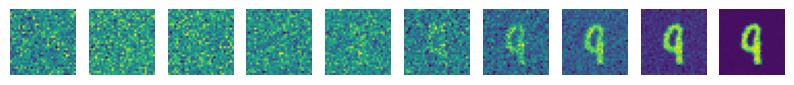

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0285066803395746
DDPM Drift Force (React): 0.21180670441687108
Starting inference on cpu with 1000 steps...


999it [00:23, 42.31it/s]


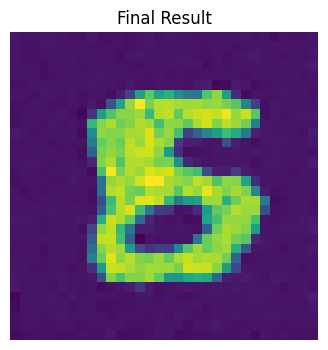

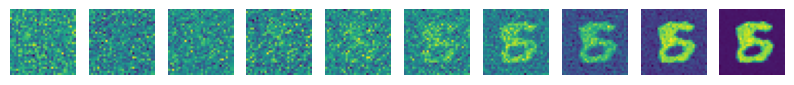

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.026858725786209
DDPM Drift Force (React): 0.21196051090955734


In [ ]:
for _ in range(n_simul):
    history_ddpm_mnist = inference(ddpm_model=ddpm_model_mnist, checkpoint_path="checkpoints/ddpm_checkpoint_mnist", num_time_steps=n_T, channels=1, img_size=32)
    ddpm_diff_mnist, ddpm_react_mnist, ddpm_diff_list_mnist, ddpm_react_list_mnist = run_ddpm_exp(history_ddpm_mnist)
    ddpm_diff_mean_list_mnist.append(ddpm_diff_mnist)
    ddpm_react_mean_list_mnist.append(ddpm_react_mnist)
    ddpm_diff_history_list_mnist.append(ddpm_diff_list_mnist)
    ddpm_react_history_list_mnist.append(ddpm_react_list_mnist)

Starting inference on cpu with 1000 steps...


999it [00:23, 43.28it/s]


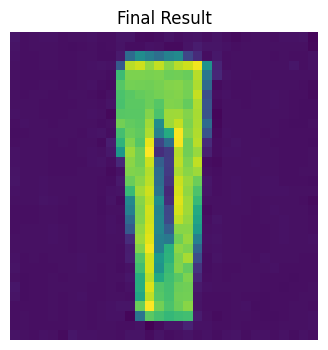

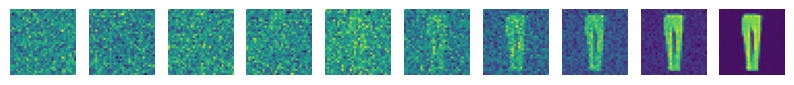

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0304412997961045
DDPM Drift Force (React): 0.21795781904459
Starting inference on cpu with 1000 steps...


999it [00:29, 33.89it/s]


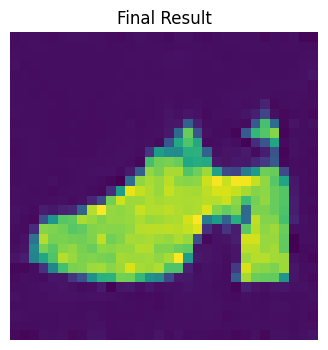

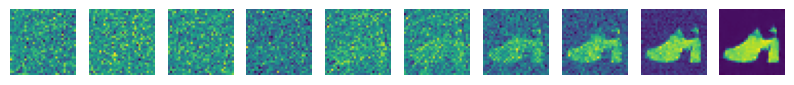

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.02887756216526
DDPM Drift Force (React): 0.21780757375061513
Starting inference on cpu with 1000 steps...


999it [00:27, 36.30it/s]


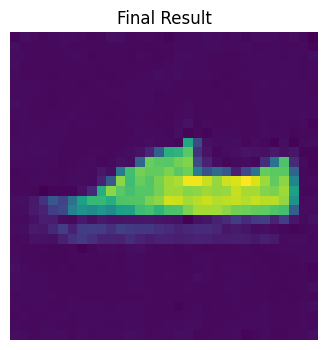

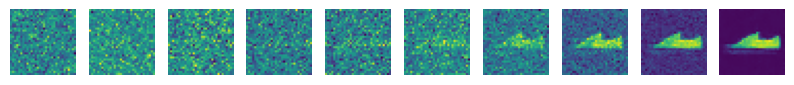

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0302367420494556
DDPM Drift Force (React): 0.21566161827743052


In [ ]:
for _ in range(n_simul):
    history_ddpm_fashion = inference(ddpm_model=ddpm_model_fashion, checkpoint_path="checkpoints/ddpm_checkpoint_fashion", num_time_steps=n_T, channels=1, img_size=32)
    ddpm_diff_fashion, ddpm_react_fashion, ddpm_diff_list_fashion, ddpm_react_list_fashion = run_ddpm_exp(history_ddpm_fashion)
    ddpm_diff_mean_list_fashion.append(ddpm_diff_fashion)
    ddpm_react_mean_list_fashion.append(ddpm_react_fashion)
    ddpm_diff_history_list_fashion.append(ddpm_diff_list_fashion)
    ddpm_react_history_list_fashion.append(ddpm_react_list_fashion)

In [ ]:
from timm.utils import ModelEmaV3
from ddpm import DDPM_Scheduler

def inference_(ddpm_model,
              checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999,
              device: str="cpu",
              channels: int=3, 
              img_size: int=32
              ):

    model = ddpm_model.to(device)
    ema = ModelEmaV3(model, decay=ema_decay)

    if checkpoint_path is not None:
        if device=="cpu":
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        else:
            checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    history = {
        "x": [],
        "drift": [],
        "diffusion": [],
        "time": []
    }

    print(f"Starting inference on {device} with {num_time_steps} steps...")

    with torch.no_grad():
        model = ema.module.eval()

        # FIX 1: Use 'channels' instead of hardcoded 1
        z = torch.randn(1, channels, img_size, img_size).to(device)

        # Reverse Diffusion Loop (T -> 0)
        for t in tqdm(reversed(range(1, num_time_steps))):
            t_tensor = torch.tensor([t], device=device)
            t_list = [t]

            pred_noise = model(z, t_tensor)

            beta_t = scheduler.beta[t_list]
            alpha_bar_t = scheduler.alpha[t_list]
            alpha_t = 1 - beta_t

            term1 = 1 / torch.sqrt(alpha_t)
            term2 = beta_t / (torch.sqrt(1 - alpha_bar_t) * torch.sqrt(alpha_t))

            mean = term1 * z - term2 * pred_noise.cpu()
            drift_term = mean - z

            # FIX 2: Noise must match z shape (channels=3)
            noise = torch.randn(1, channels, img_size, img_size)
            
            sigma = torch.sqrt(beta_t)
            diffusion_term = sigma * noise

            z_prev = mean + diffusion_term

            history["x"].append(z.cpu().numpy())
            history["drift"].append(drift_term.cpu().numpy())
            history["diffusion"].append(diffusion_term.cpu().numpy())
            history["time"].append(t)

            if t in times:
                images.append(z)

            z = z_prev.to(device)

        # Final Step (t=0)
        t0_list = [0]
        beta_0 = scheduler.beta[t0_list]
        alpha_bar_0 = scheduler.alpha[t0_list]
        alpha_0 = 1 - beta_0

        pred_noise_0 = model(z, torch.tensor([0], device=device))

        term1_0 = 1 / torch.sqrt(alpha_0)
        term2_0 = beta_0 / (torch.sqrt(1 - alpha_bar_0) * torch.sqrt(alpha_0))

        mean_0 = term1 * z - term2 * pred_noise.cpu() # Note: logic check here, usually mean_0 calculation uses term1_0/term2_0
        drift_term_0 = mean_0 - z

        # FIX 3: Final noise must match channels
        noise = torch.randn(1, channels, img_size, img_size)
        
        sigma = torch.sqrt(beta_t) # Note: usually beta_0 or 0 for final step depending on variant
        diffusion_term_0 = sigma * noise

        x_final = term1_0 * z - term2_0 * pred_noise_0.cpu()

        history["x"].append(x_final.cpu().numpy())
        history["drift"].append(drift_term_0.cpu().numpy())
        history["diffusion"].append(diffusion_term_0.cpu().numpy())
        history["time"].append(0)

        images.append(x_final)

        if len(images) > 0:
            final_img = x_final.cpu().squeeze().numpy()
            # Handle CHW -> HWC for plotting RGB
            if final_img.shape[0] == 3:
                final_img = np.transpose(final_img, (1, 2, 0))
                # Normalize to [0,1] for display if your training data was normalized
                final_img = (final_img - final_img.min()) / (final_img.max() - final_img.min())
            
            plt.figure(figsize=(4,4))
            plt.imshow(final_img, cmap='gray' if channels==1 else None)
            plt.title("Final Result")
            plt.axis('off')
            plt.show()

            #display_reverse(images)

    return history


Starting inference on cpu with 1000 steps...


999it [00:34, 28.83it/s]


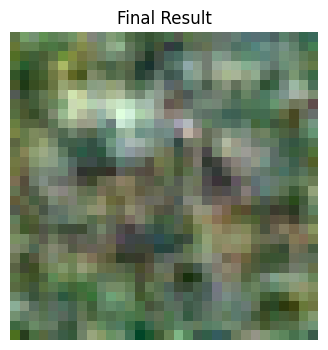

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.249576066672802
DDPM Drift Force (React): 0.3586763786077499
Starting inference on cpu with 1000 steps...


999it [00:31, 31.66it/s]


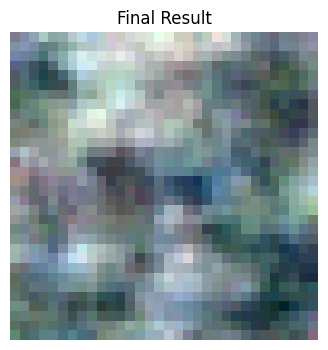

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.248147609472275
DDPM Drift Force (React): 0.3602465822994709
Starting inference on cpu with 1000 steps...


999it [00:30, 33.26it/s]


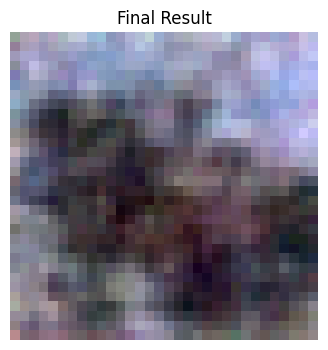

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.246655948758125
DDPM Drift Force (React): 0.35863896721601485


In [43]:
for _ in range(n_simul):
    history_ddpm_cifar = inference_(ddpm_model=ddpm_model_cifar, checkpoint_path="checkpoints/ddpm_checkpoint_cifar", num_time_steps=n_T, channels=3, img_size=32)
    ddpm_diff_cifar, ddpm_react_cifar, ddpm_diff_list_cifar, ddpm_react_list_cifar = run_ddpm_exp(history_ddpm_cifar)
    ddpm_diff_mean_list_cifar.append(ddpm_diff_cifar)
    ddpm_react_mean_list_cifar.append(ddpm_react_cifar)
    ddpm_diff_history_list_cifar.append(ddpm_diff_list_cifar)
    ddpm_react_history_list_cifar.append(ddpm_react_list_cifar)

In [44]:
# Calculate Ratios
rd_ratio = rd_react / (rd_diff if rd_diff != 0 else rd_diff + 1e-10)
lstm_ratio_sine = lstm_react_sine / (lstm_diff_sine if lstm_diff_sine != 0 else lstm_diff_sine + 1e-10)
lstm_ratio_lorenz = lstm_react_lorenz / (lstm_diff_lorenz if lstm_diff_lorenz != 0 else lstm_diff_lorenz + 1e-10)
ddpm_ratio_mnist = ddpm_react_mnist / (ddpm_diff_mnist if ddpm_diff_mnist != 0 else ddpm_diff_mnist + 1e-10)
ddpm_ratio_fashion = ddpm_react_fashion / (ddpm_diff_fashion if ddpm_diff_fashion != 0 else ddpm_diff_fashion + 1e-10)
ddpm_ratio_cifar = ddpm_react_cifar / (ddpm_diff_cifar if ddpm_diff_cifar != 0 else ddpm_diff_cifar + 1e-10)

print(f"{'Model':<20} | {'M_diff (Decay)':<18} | {'M_react (Growth)':<18} | {'Ratio (react/diff)':<15}")
print("-" * 80)
print(f"{'Gray-Scott (RD)':<20} | {rd_diff:<18.8f} | {rd_react:<18.8f} | {rd_ratio:<15.8f}")
print(f"{'LSTM (sine)':<20} | {lstm_diff_sine:<18.8f} | {lstm_react_sine:<18.8f} | {lstm_ratio_sine:<15.8f}")
print(f"{'LSTM (lorenz)':<20} | {lstm_diff_lorenz:<18.8f} | {lstm_react_lorenz:<18.8f} | {lstm_ratio_lorenz:<15.8f}")
print(f"{'DDPM (mnist)':<20} | {ddpm_diff_mnist:<18.8f} | {ddpm_react_mnist:<18.8f} | {ddpm_ratio_mnist:<15.8f}")
print(f"{'DDPM (fashion)':<20} | {ddpm_diff_fashion:<18.8f} | {ddpm_react_fashion:<18.8f} | {ddpm_ratio_fashion:<15.8f}")
print(f"{'DDPM (cifar)':<20} | {ddpm_diff_cifar:<18.8f} | {ddpm_react_cifar:<18.8f} | {ddpm_ratio_cifar:<15.8f}")

Model                | M_diff (Decay)     | M_react (Growth)   | Ratio (react/diff)
--------------------------------------------------------------------------------
Gray-Scott (RD)      | 0.13501491         | 0.13881408         | 1.02813889     
LSTM (sine)          | 1.54000703         | 1.54898268         | 1.00582832     
LSTM (lorenz)        | 1.73776732         | 1.76532327         | 1.01585710     
DDPM (mnist)         | 3.02953883         | 0.21317946         | 0.07036697     
DDPM (fashion)       | 3.03229232         | 0.21313865         | 0.07028961     
DDPM (cifar)         | 5.24665595         | 0.35863897         | 0.06835572     


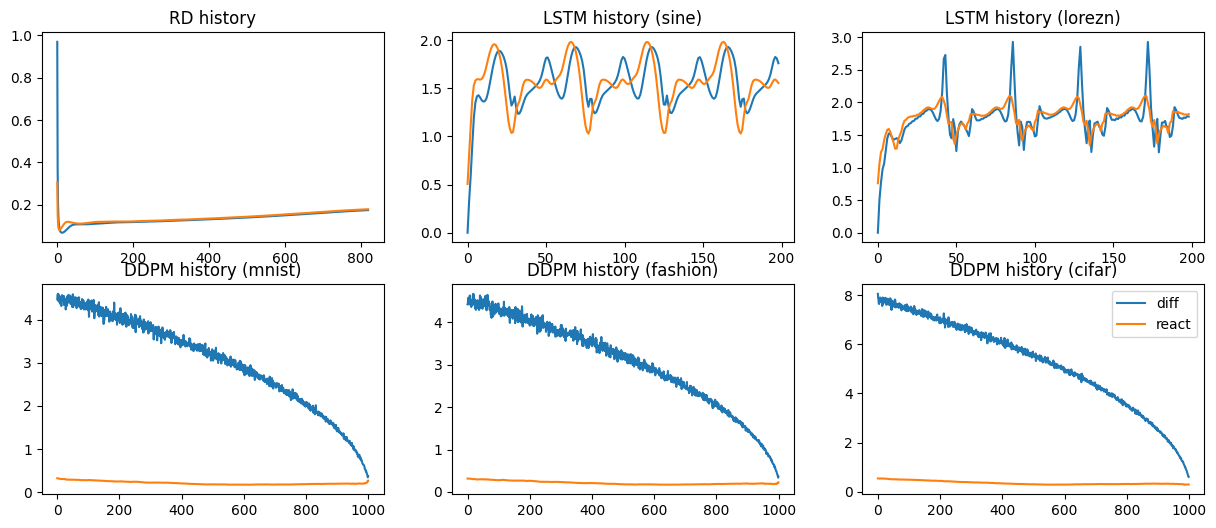

In [45]:
fig, ax = plt.subplots(2,3, figsize=(15,6))

rand_index = random.randint(0,200)
ax[0,0].plot(rd_diff_list, label="diff")
ax[0,0].plot(rd_react_list, label="react")
ax[0,0].set_title("RD history")

ax[0,1].plot(lstm_diff_list_sine, label="diff")
ax[0,1].plot(lstm_react_list_sine, label="react")
ax[0,1].set_title("LSTM history (sine)")

ax[0,2].plot(lstm_diff_list_lorenz, label="diff")
ax[0,2].plot(lstm_react_list_lorenz, label="react")
ax[0,2].set_title("LSTM history (lorezn)")

ax[1,0].plot(ddpm_diff_list_mnist, label="diff")
ax[1,0].plot(ddpm_react_list_mnist, label="react")
ax[1,0].set_title("DDPM history (mnist)")

ax[1,1].plot(ddpm_diff_list_fashion, label="diff")
ax[1,1].plot(ddpm_react_list_fashion, label="react")
ax[1,1].set_title("DDPM history (fashion)")

ax[1,2].plot(ddpm_diff_list_cifar, label="diff")
ax[1,2].plot(ddpm_react_list_cifar, label="react")
ax[1,2].set_title("DDPM history (cifar)")

plt.legend()
plt.show()

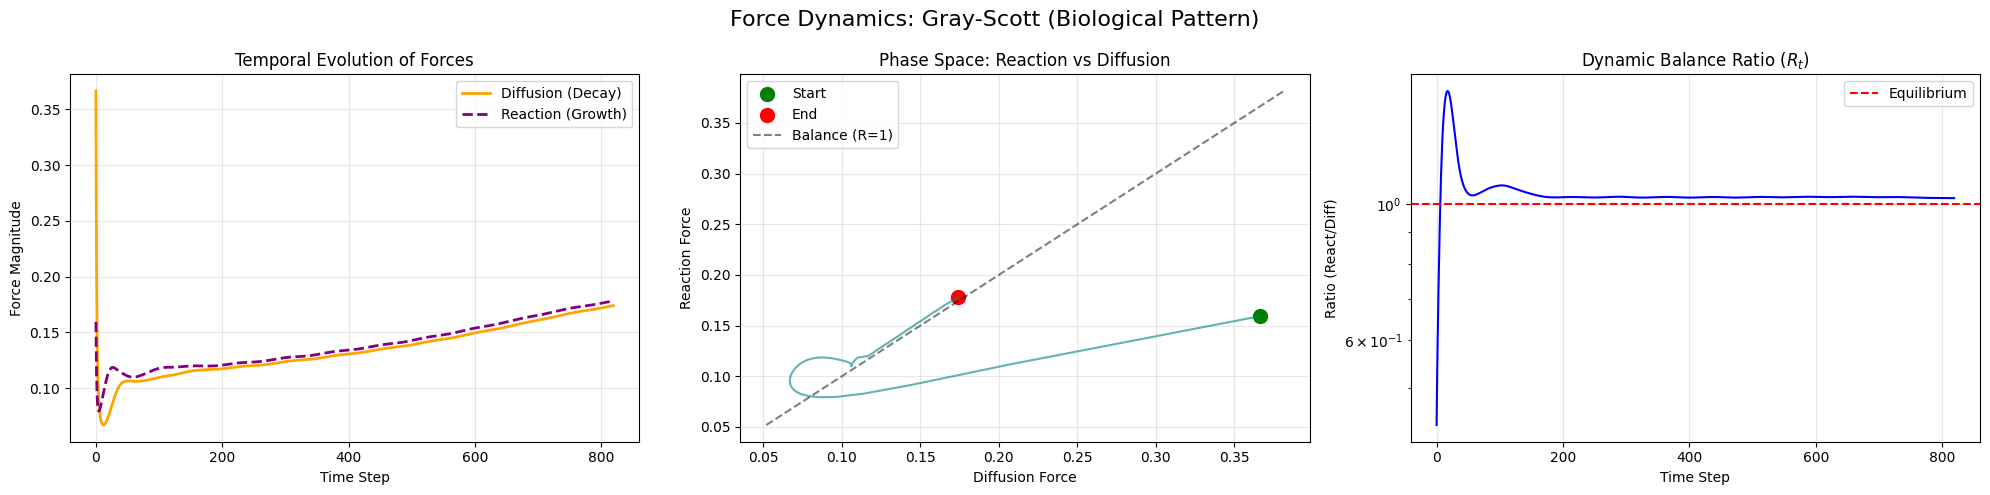

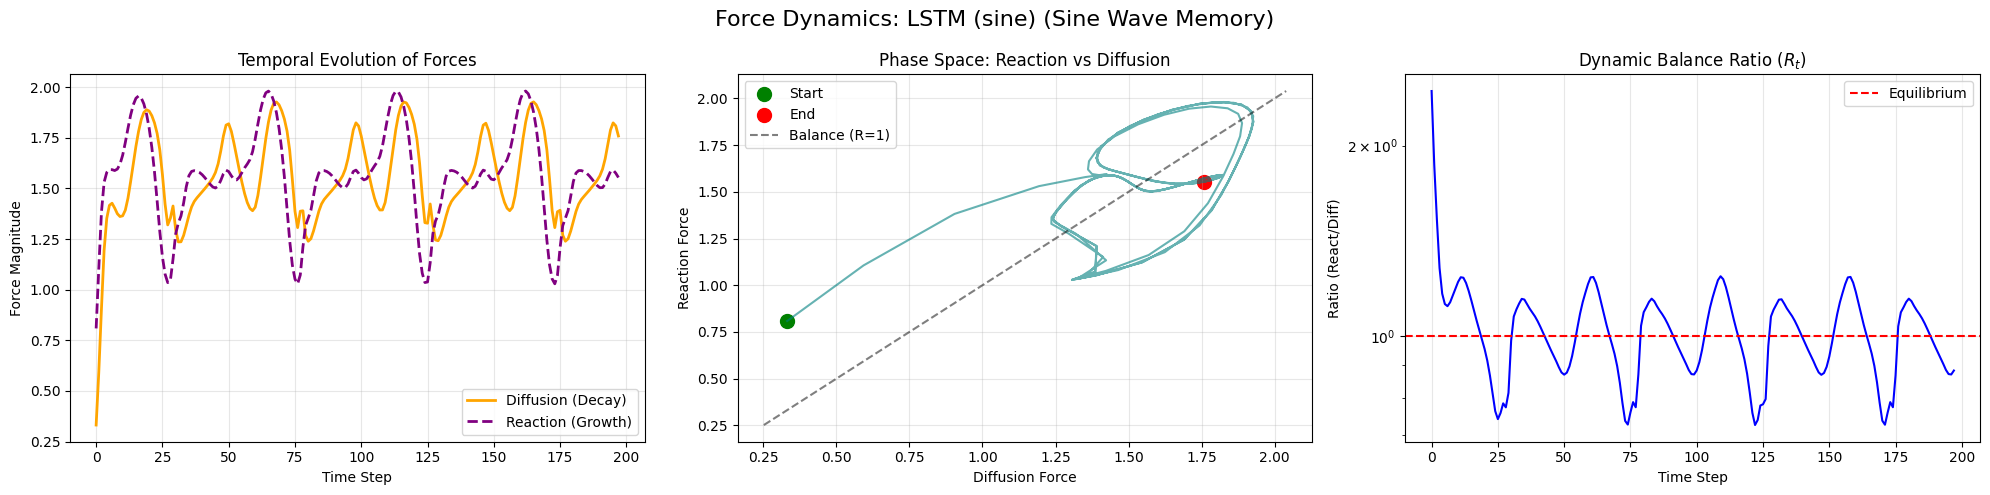

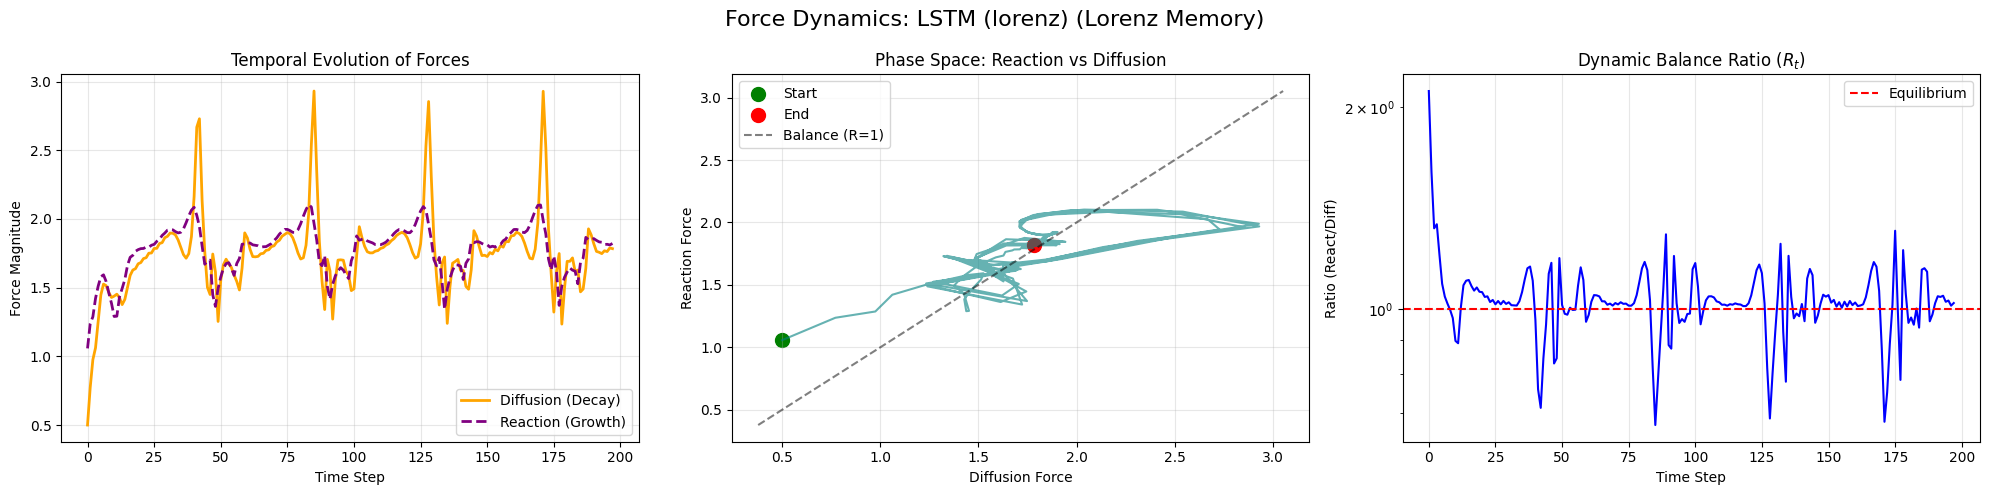

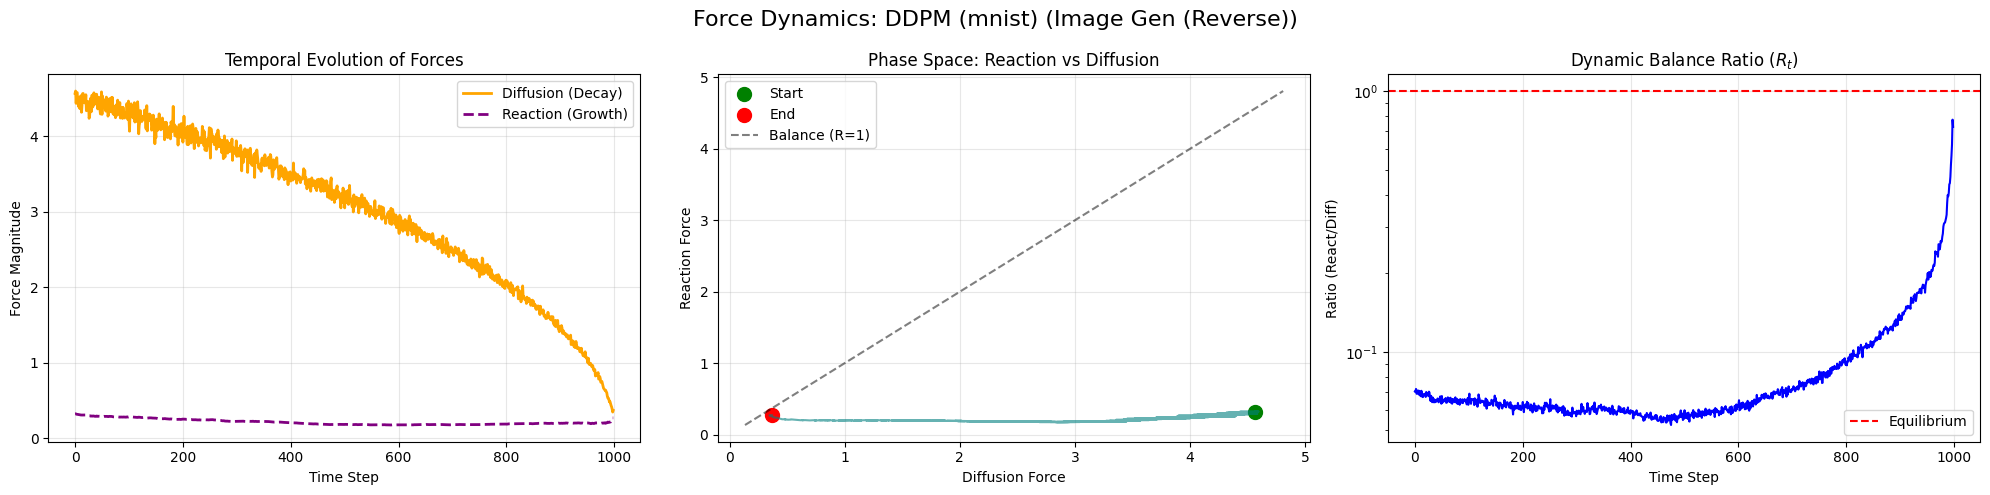

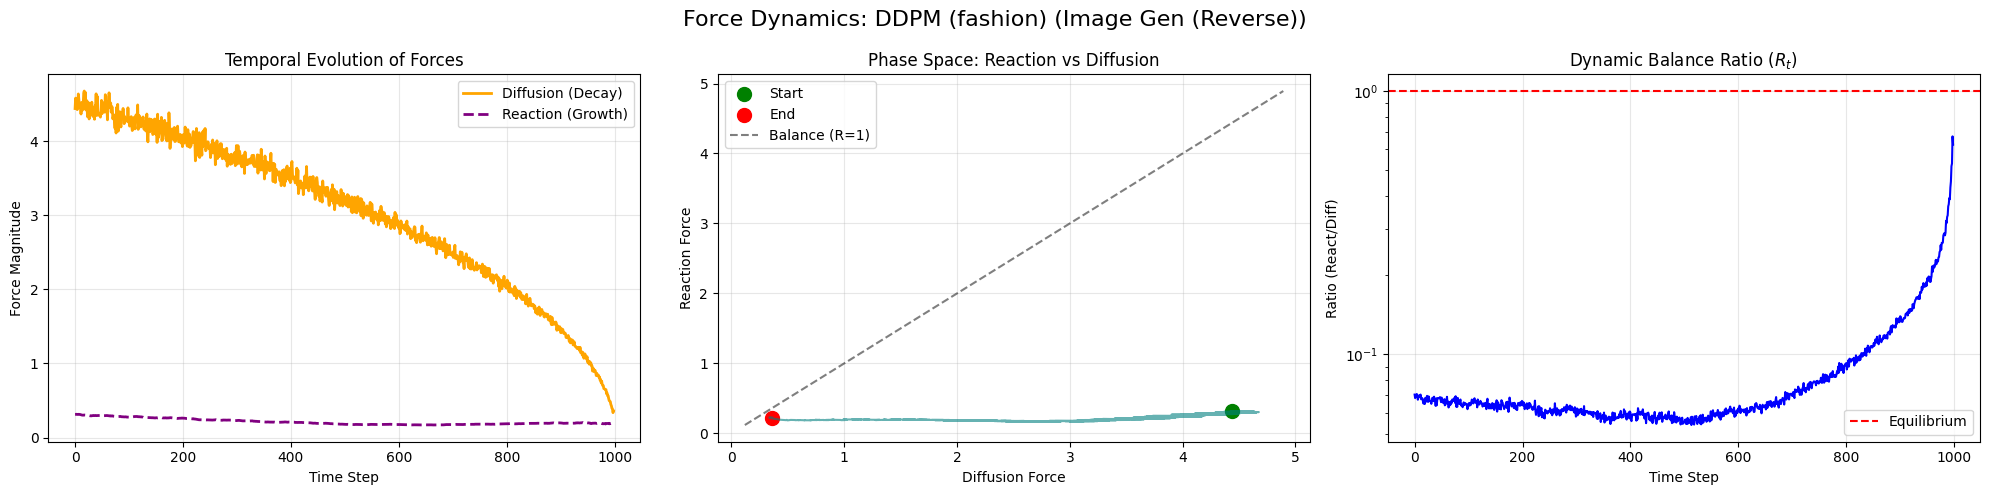

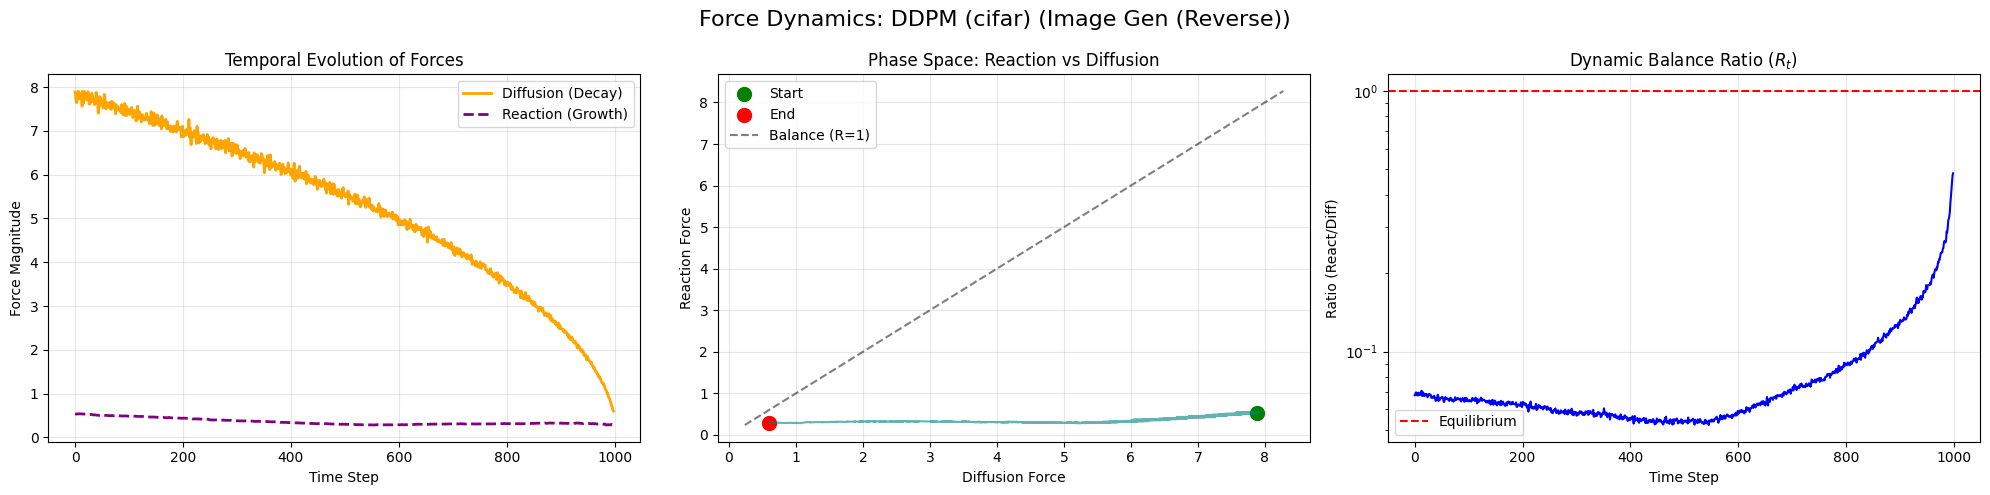

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_forces(model_name, diff_forces, react_forces, task_type="Static"):
    """
    Generates a 3-panel analysis dashboard for a single model.
    """
    # Normalize time axis
    steps = np.arange(len(diff_forces))
    
    # # Smooth data for cleaner plotting (optional moving average)
    # def smooth(y, box_pts=10):
    #     if len(y) < 20: return y
    #     box = np.ones(box_pts)/box_pts
    #     return np.convolve(y, box, mode='same')

    # d_smooth = smooth(np.array(diff_forces))
    # r_smooth = smooth(np.array(react_forces))

    d_smooth = np.array(diff_forces)
    r_smooth = np.array(react_forces)

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"Force Dynamics: {model_name} ({task_type})", fontsize=16)

    # --- Plot 1: Temporal Evolution (The "Battle") ---
    # Shows how forces compete over time
    axes[0].plot(steps, d_smooth, label='Diffusion (Decay)', color='orange', linewidth=2)
    axes[0].plot(steps, r_smooth, label='Reaction (Growth)', color='purple', linewidth=2, linestyle='--')
    axes[0].set_title("Temporal Evolution of Forces")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Force Magnitude")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # --- Plot 2: Phase Space (The "Attractor") ---
    # Shows the system's stability signature
    axes[1].plot(d_smooth, r_smooth, color='teal', alpha=0.6)
    # Mark start and end
    axes[1].scatter(d_smooth[0], r_smooth[0], c='green', label='Start', s=100)
    axes[1].scatter(d_smooth[-1], r_smooth[-1], c='red', label='End', s=100)
    # Add y=x line (Perfect Balance)
    lims = [
        np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
        np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
    ]
    axes[1].plot(lims, lims, 'k--', alpha=0.5, label='Balance (R=1)')
    axes[1].set_title("Phase Space: Reaction vs Diffusion")
    axes[1].set_xlabel("Diffusion Force")
    axes[1].set_ylabel("Reaction Force")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # --- Plot 3: Balance Ratio Evolution ---
    # Shows how the "Goldilocks" ratio changes
    # Avoid div by zero
    ratio = r_smooth / (d_smooth + 1e-9)
    axes[2].plot(steps, ratio, color='blue')
    axes[2].axhline(y=1.0, color='r', linestyle='--', label='Equilibrium')
    axes[2].set_title("Dynamic Balance Ratio ($R_t$)")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Ratio (React/Diff)")
    axes[2].set_yscale('log') # Log scale often reveals more details
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example Usage (Replace with your actual data variables)
analyze_forces("Gray-Scott", rd_diff_list[1:], rd_react_list[1:], "Biological Pattern")
analyze_forces("LSTM (sine)", lstm_diff_list_sine[1:], lstm_react_list_sine[1:], "Sine Wave Memory")
analyze_forces("LSTM (lorenz)", lstm_diff_list_lorenz[1:], lstm_react_list_lorenz[1:], "Lorenz Memory")
analyze_forces("DDPM (mnist)", ddpm_diff_list_mnist[1:], ddpm_react_list_mnist[1:], "Image Gen (Reverse)")
analyze_forces("DDPM (fashion)", ddpm_diff_list_fashion[1:], ddpm_react_list_fashion[1:], "Image Gen (Reverse)")
analyze_forces("DDPM (cifar)", ddpm_diff_list_cifar[1:], ddpm_react_list_cifar[1:], "Image Gen (Reverse)")